In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join
import scipy.io
from mpl_toolkits import mplot3d
%matplotlib widget

In [18]:
monRepertoire = '../../Mesures/TestUlysse/table_acier_corde_article/'
fichiers = [f for f in listdir(monRepertoire) if (isfile(join(monRepertoire, f)) and 'txt' not in f)]
data={}
k=0
for fichier in fichiers:
    with open(monRepertoire+fichier, 'rb') as f:
        data_seul = pickle.load(f)
    data[list(data_seul.keys())[0]+str(k)] = data_seul[list(data_seul.keys())[0]]
    k+=1
    
all_cle = list(data.keys())

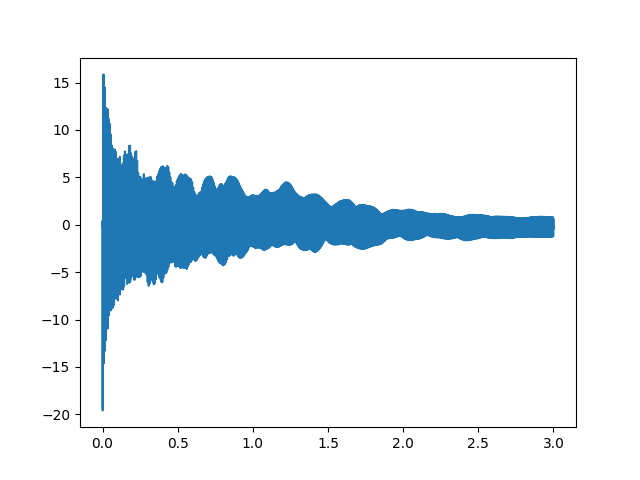

In [19]:
x = data[all_cle[0]]['data']
Fe = data[all_cle[0]]['Fe']
t = np.linspace(0,3, 3*Fe)
plt.figure()
plt.plot(t, x)

In [20]:
display(Audio(x, rate=Fe))
print('ok')

ok


In [21]:
M = np.zeros((len(x), len(data.keys())))
x_axis = np.zeros(len(data.keys()))
y_axis = np.zeros(len(data.keys()))

i=0
for cle in all_cle:
    M[:,i] = data[cle]['data']
    x_axis[i] = data[cle]['rho_table']
    y_axis[i] = data[cle]['E_table']
    i+=1
    

In [6]:
def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope


def compute_features(data, sr, S=None, n_fft=2048, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features

In [7]:
data_features={}
for k in range(len(data.keys())):
    data_features[all_cle[k]] = compute_features(M[:,k], sr=Fe, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85)

In [8]:
#Ou commencer et finir la visualtion
debut = 100
fin = -10

In [9]:
liste_categorie = ['table_acier_corde_article']
dict_categorie_nombre = {}

In [10]:
for categorie in liste_categorie:
    dict_categorie_nombre[categorie] = all_cle.count(categorie)

In [11]:
M_spec_bw = np.zeros((len(data_features[all_cle[0]]['spectral_bandwidth'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_spec_bw[:,i] = data_features[cle]['spectral_bandwidth'][0]
    i+=1
    
M_cent = np.zeros((len(data_features[all_cle[0]]['spectral_centroid'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_cent[:,i] = data_features[cle]['spectral_centroid'][0]
    i+=1

M_contrast = np.zeros((len(data_features[all_cle[0]]['spectral_contrast'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_contrast[:,i] = data_features[cle]['spectral_contrast'][0]
    i+=1
    
M_flatness = np.zeros((len(data_features[all_cle[0]]['spectral_flatness'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_flatness[:,i] = data_features[cle]['spectral_flatness'][0]
    i+=1
    
M_slope = np.zeros((len(data_features[all_cle[0]]['spectral_slope'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_slope[:,i] = data_features[cle]['spectral_slope'][0]
    i+=1

M_rolloff = np.zeros((len(data_features[all_cle[0]]['spectral_rolloff'][0]),len(data.keys())))
i=0
for cle in all_cle:
    M_rolloff[:,i] = data_features[cle]['spectral_rolloff'][0]
    i+=1

In [12]:
M_spec_bw_mean = np.mean(M_spec_bw[debut:fin,:] /np.max(np.abs(M_spec_bw[debut:fin,:])), axis=0)
M_cent_mean = np.mean(M_cent[debut:fin,:] /np.max(np.abs(M_cent[debut:fin,:])), axis=0)
M_contrast_mean = np.mean(M_contrast[debut:fin,:] /np.max(np.abs(M_contrast[debut:fin,:])), axis=0)
M_flatness_mean = np.mean(M_flatness[debut:fin,:] /np.max(np.abs(M_flatness[debut:fin,:])), axis=0)
M_slope_mean = np.mean(M_slope[debut:fin,:] /np.max(np.abs(M_slope[debut:fin,:])), axis=0)
M_rolloff_mean = np.mean(M_rolloff[debut:fin,:] /np.max(np.abs(M_rolloff[debut:fin,:])), axis=0)

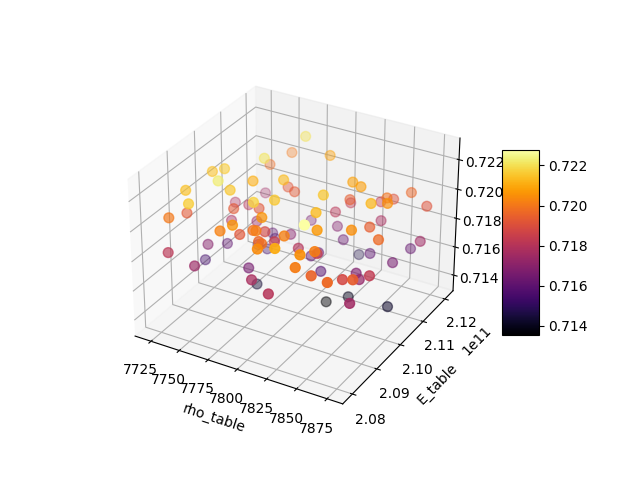

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
z_data = M_spec_bw_mean
my_cmap = plt.get_cmap('inferno')
sctt = ax.scatter3D(x_axis,y_axis,z_data, c=z_data,cmap = my_cmap,marker ='o', s=50)
ax.set_xlabel('rho_table')
ax.set_ylabel('E_table')
ax.set_zlabel('spec_bw_mean')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

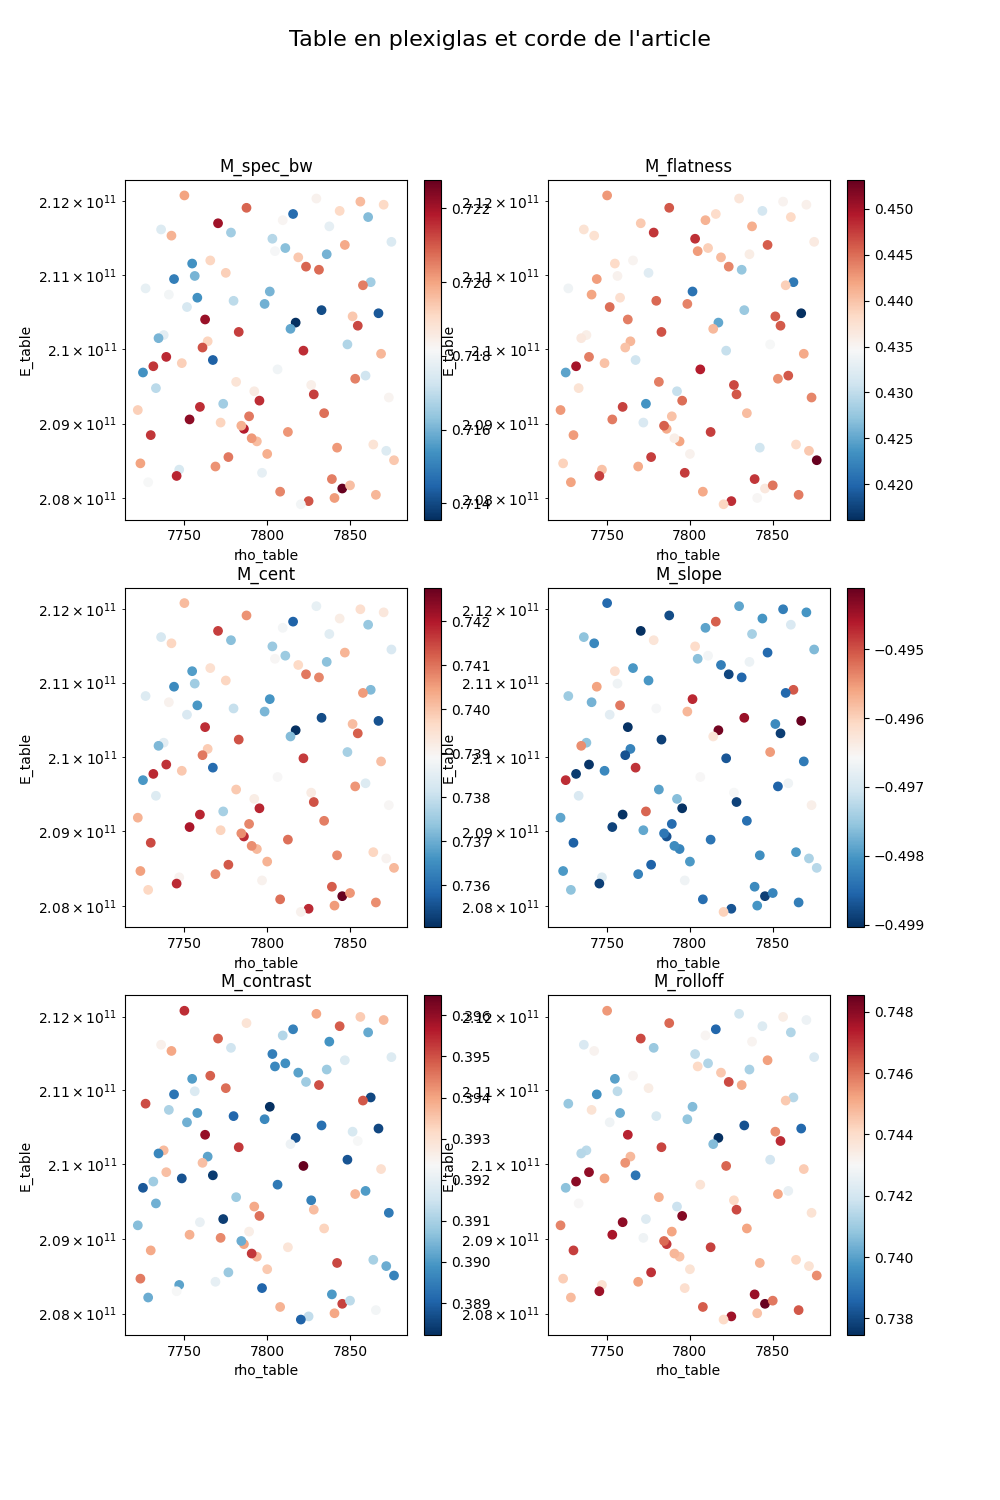

In [14]:
fig, ax = plt.subplots(3,2, figsize=(10,15))

fig.suptitle("Table en plexiglas et corde de l'article", fontsize=16)


a=ax[0,0].scatter(x_axis,y_axis,c=M_spec_bw_mean, cmap = 'RdBu_r')
b=ax[1,0].scatter(x_axis,y_axis,c=M_cent_mean, cmap = 'RdBu_r')
c=ax[2,0].scatter(x_axis,y_axis,c=M_contrast_mean, cmap = 'RdBu_r')
d=ax[0,1].scatter(x_axis,y_axis,c=M_flatness_mean, cmap = 'RdBu_r')
e=ax[1,1].scatter(x_axis,y_axis,c=M_slope_mean, cmap = 'RdBu_r')
f=ax[2,1].scatter(x_axis,y_axis,c=M_rolloff_mean, cmap = 'RdBu_r')

ax[0,0].set_title("M_spec_bw")
ax[1,0].set_title("M_cent")
ax[2,0].set_title("M_contrast")
ax[0,1].set_title("M_flatness") 
ax[1,1].set_title("M_slope")
ax[2,1].set_title("M_rolloff")

for i in range(3):
    for j in range(2):
        ax[i,j].set(xlabel='rho_table', ylabel='E_table')


fig.colorbar(a, ax=ax[0,0])
fig.colorbar(b, ax=ax[1,0])
fig.colorbar(c, ax=ax[2,0])
fig.colorbar(d, ax=ax[0,1])
fig.colorbar(e, ax=ax[1,1])
fig.colorbar(f, ax=ax[2,1])
for i in range(3):
    for j in range(2):
        ax[i,j].set_yscale('log')